In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random

In [3]:
# ---------------------------
# STEP 1: Load & Inspect Data
# ---------------------------
df = pd.read_csv("/Users/tmukherjee/Desktop/NTU/Academics/Y4S2/FYP_S2/Training Data/Final_Cleaned_Bouba-Kiki_Dataset.csv")

# Basic vowel map for rule-based phoneme conversion
vowel_map = {
    'a': 'AH', 'e': 'EH', 'i': 'IY', 'o': 'OW', 'u': 'UW',
    'ai': 'AY', 'ou': 'AW', 'oo': 'UW', 'ee': 'IY'
}

In [5]:
def basic_phoneme_converter(word):
    word = word.lower()
    phonemes = []
    i = 0
    while i < len(word):
        # Check for digraphs (e.g., 'oo', 'ee', 'ai', 'ou')
        if i + 1 < len(word) and word[i:i+2] in vowel_map:
            phonemes.append(vowel_map[word[i:i+2]])
            i += 2
        elif word[i] in vowel_map:
            phonemes.append(vowel_map[word[i]])
            i += 1
        elif word[i].isalpha():
            phonemes.append(word[i])
            i += 1
        else:
            i += 1  # skip non-letter characters
    return phonemes

In [7]:
# Apply the phoneme converter if not already done
if "Phonemes" not in df.columns or df["Phonemes"].isnull().all():
    df['Phonemes'] = df['Pseudoword'].apply(basic_phoneme_converter)

print("\n[INFO] Sample rows with phonemes:")
print(df[['Pseudoword','Phonemes','Boubaness','Kikiness']].head(5))


[INFO] Sample rows with phonemes:
  Pseudoword        Phonemes  Boubaness  Kikiness
0       guga  [g, UW, g, AH]       0.91      0.09
1       buba  [b, UW, b, AH]       0.82      0.18
2       pupa  [p, UW, p, AH]       0.80      0.20
3       bibe  [b, IY, b, EH]       0.76      0.24
4       kike  [k, IY, k, EH]       0.15      0.85


In [9]:
# ---------------------------
# STEP 2: Build Phoneme Vocabulary
# ---------------------------
all_phonemes = []
for seq in df['Phonemes']:
    all_phonemes.extend(seq)

phoneme_counts = Counter(all_phonemes)
vocab = ["<PAD>", "<UNK>"] + sorted(phoneme_counts.keys())
phoneme_to_id = {p: i for i, p in enumerate(vocab)}
vocab_size = len(vocab)

print(f"[INFO] Vocab size = {vocab_size}")
print("[INFO] Sample of vocab:", vocab[:20])

[INFO] Vocab size = 24
[INFO] Sample of vocab: ['<PAD>', '<UNK>', 'AH', 'AW', 'EH', 'IY', 'OW', 'UW', 'b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p']


In [11]:
# ---------------------------
# STEP 3: Convert Sequences to Integer IDs & Pad
# ---------------------------
max_len = max(len(seq) for seq in df['Phonemes'])
print(f"[INFO] Longest phoneme sequence length = {max_len}")

def encode_and_pad(phoneme_seq, max_len):
    ids = []
    for ph in phoneme_seq:
        if ph in phoneme_to_id:
            ids.append(phoneme_to_id[ph])
        else:
            ids.append(phoneme_to_id["<UNK>"])
    if len(ids) < max_len:
        ids += [phoneme_to_id["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

[INFO] Longest phoneme sequence length = 7


In [13]:
X_list = []
y_list = []

for idx, row in df.iterrows():
    phon_seq = row['Phonemes']
    bouba_score = row['Boubaness']  # We'll model boubaness; kikiness = 1 - boubaness
    encoded_seq = encode_and_pad(phon_seq, max_len)
    X_list.append(encoded_seq)
    y_list.append(bouba_score)

X = np.array(X_list)
y = np.array(y_list).astype('float32')

print("[INFO] Example encoded sequence:\n", X[0])
print("[INFO] Example target boubaness:", y[0])

[INFO] Example encoded sequence:
 [12  7 12  2  0  0  0]
[INFO] Example target boubaness: 0.91


In [17]:
# ---------------------------
# STEP 4: Train-Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("[INFO] Train size:", len(X_train), "Test size:", len(X_test))

# ---------------------------
# STEP 5: Build a Simple Model
# ---------------------------
model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=16),
    layers.Bidirectional(layers.LSTM(16, return_sequences=False)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # output in [0,1] for boubaness
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

[INFO] Train size: 152 Test size: 38


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# ---------------------------
# STEP 6: Train the Model
# ---------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=8,
    verbose=1
)

# ---------------------------
# STEP 7: Evaluate
# ---------------------------
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"[RESULT] Test MSE = {loss:.4f}, Test MAE = {mae:.4f}")

# Example prediction
test_idx = 0
pred_bouba = model.predict(X_test[test_idx:test_idx+1])[0][0]
true_bouba = y_test[test_idx]
print(f"Predicted boubaness: {pred_bouba:.3f} vs. Actual: {true_bouba:.3f}")
print(f"Kikiness (implied) = {1 - pred_bouba:.3f}")

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0844 - mae: 0.2621 - val_loss: 0.0690 - val_mae: 0.2392
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0785 - mae: 0.2560 - val_loss: 0.0631 - val_mae: 0.2300
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0735 - mae: 0.2436 - val_loss: 0.0559 - val_mae: 0.2167
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0624 - mae: 0.2242 - val_loss: 0.0444 - val_mae: 0.1862
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0448 - mae: 0.1846 - val_loss: 0.0355 - val_mae: 0.1644
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0324 - mae: 0.1555 - val_loss: 0.0292 - val_mae: 0.1475
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - mae: 0.1222 - val_loss: 0.0305 - val_mae: 0.1393
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214 - mae: 0.1086 - val_loss: 0.0305 - val_mae: 0.1363
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212 - mae: 

In [29]:
# ------------------------------------------------
# STEP 8: Manual Hyperparameter Tuning (Added)
# ------------------------------------------------
def build_and_train_model(emb_size, lstm_units, dense_units, 
                          batch_size=8, epochs=30):
    """Build, train, and evaluate a model with the given hyperparams. 
       Returns final test MSE, test MAE."""
    
    # 1) Build
    m = models.Sequential()
    m.add(layers.Embedding(input_dim=vocab_size, output_dim=emb_size))
    m.add(layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False)))
    m.add(layers.Dense(dense_units, activation='relu'))
    m.add(layers.Dense(1, activation='sigmoid'))
    
    m.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # 2) Train with early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    hist = m.fit(X_train, y_train,
                 validation_split=0.2,
                 epochs=epochs,
                 batch_size=batch_size,
                 callbacks=[early_stop],
                 verbose=0)  # set verbose=1 to watch training
    
    # 3) Evaluate
    test_loss, test_mae = m.evaluate(X_test, y_test, verbose=0)
    return test_loss, test_mae

# Define a small grid of hyperparams to try
emb_sizes = [8, 16]
lstm_unit_options = [16, 32]
dense_unit_options = [8, 16]
batch_sizes = [4, 8]

best_combo = None
best_mse = 999
results = []

print("\n[HYPERPARAM TUNING RESULTS]")
for emb in emb_sizes:
    for lstm_u in lstm_unit_options:
        for dense_u in dense_unit_options:
            for bsz in batch_sizes:
                mse, mae = build_and_train_model(emb, lstm_u, dense_u, bsz, epochs=20)
                results.append((emb, lstm_u, dense_u, bsz, mse, mae))
                if mse < best_mse:
                    best_mse = mse
                    best_combo = (emb, lstm_u, dense_u, bsz, mse, mae)
                print(f" emb={emb}, lstm={lstm_u}, dense={dense_u}, batch={bsz} => MSE={mse:.4f}, MAE={mae:.4f}")

print("\n[BEST MODEL CONFIG]")
print("Embedding size:", best_combo[0])
print("LSTM units:", best_combo[1])
print("Dense units:", best_combo[2])
print("Batch size:", best_combo[3])
print(f"Test MSE={best_combo[4]:.4f}, Test MAE={best_combo[5]:.4f}")


[HYPERPARAM TUNING RESULTS]
 emb=8, lstm=16, dense=8, batch=4 => MSE=0.0345, MAE=0.1563
 emb=8, lstm=16, dense=8, batch=8 => MSE=0.0360, MAE=0.1576
 emb=8, lstm=16, dense=16, batch=4 => MSE=0.0365, MAE=0.1584
 emb=8, lstm=16, dense=16, batch=8 => MSE=0.0369, MAE=0.1604
 emb=8, lstm=32, dense=8, batch=4 => MSE=0.0430, MAE=0.1694
 emb=8, lstm=32, dense=8, batch=8 => MSE=0.0397, MAE=0.1668
 emb=8, lstm=32, dense=16, batch=4 => MSE=0.0358, MAE=0.1558
 emb=8, lstm=32, dense=16, batch=8 => MSE=0.0307, MAE=0.1451
 emb=16, lstm=16, dense=8, batch=4 => MSE=0.0337, MAE=0.1507
 emb=16, lstm=16, dense=8, batch=8 => MSE=0.0359, MAE=0.1574
 emb=16, lstm=16, dense=16, batch=4 => MSE=0.0336, MAE=0.1519
 emb=16, lstm=16, dense=16, batch=8 => MSE=0.0325, MAE=0.1488
 emb=16, lstm=32, dense=8, batch=4 => MSE=0.0403, MAE=0.1659
 emb=16, lstm=32, dense=8, batch=8 => MSE=0.0302, MAE=0.1419
 emb=16, lstm=32, dense=16, batch=4 => MSE=0.0359, MAE=0.1563
 emb=16, lstm=32, dense=16, batch=8 => MSE=0.0319, MAE=0.

In [31]:
# ---------------------------
# STEP 9: Build Final Model with Best Hyperparameters
# ---------------------------
# Unpack best hyperparameters from best_combo
best_emb, best_lstm, best_dense, best_batch, best_mse, best_mae = best_combo

print("\n[FINAL MODEL] Using best hyperparameters:")
print(f"Embedding size: {best_emb}, LSTM units: {best_lstm}, Dense units: {best_dense}, Batch size: {best_batch}")

# Build the final model using best hyperparameters
final_model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=best_emb),
    layers.Bidirectional(layers.LSTM(best_lstm, return_sequences=False)),
    layers.Dense(best_dense, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # output in [0,1] for boubaness
])

final_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
final_model.summary()

# Use EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the final model
history_final = final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,             # Can adjust the number of epochs
    batch_size=best_batch,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the final model on the test set
final_loss, final_mae = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\n[FINAL MODEL RESULT] Test MSE = {final_loss:.4f}, Test MAE = {final_mae:.4f}")

# Example: Make a prediction on one test sample
test_idx = 0
pred_bouba = final_model.predict(X_test[test_idx:test_idx+1])[0][0]
true_bouba = y_test[test_idx]
print(f"Predicted boubaness: {pred_bouba:.3f} vs. Actual: {true_bouba:.3f}")
print(f"Implied kikiness: {1 - pred_bouba:.3f}")



[FINAL MODEL] Using best hyperparameters:
Embedding size: 16, LSTM units: 32, Dense units: 8, Batch size: 8


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_35 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_35                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0817 - mae: 0.2553 - val_loss: 0.0748 - val_mae: 0.2466
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0852 - mae: 0.2664 - val_loss: 0.0739 - val_mae: 0.2456
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0874 - mae: 0.2688 - val_loss: 0.0726 - val_mae: 0.2441
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0831 - mae: 0.2644 - val_loss: 0.0660 - val_mae: 0.2341
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0613 - mae: 0.2236 - val_loss: 0.0514 - val_mae: 0.2055
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0426 - mae: 0.1783 - val_loss: 0.0496 - val_mae: 0.1846
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226 - mae: 0.1184 - val_loss: 0.0413 - val_mae: 0.1598
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301 - mae: 0.1328 - val_loss: 0.0369 - val_mae: 0.1569
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.019

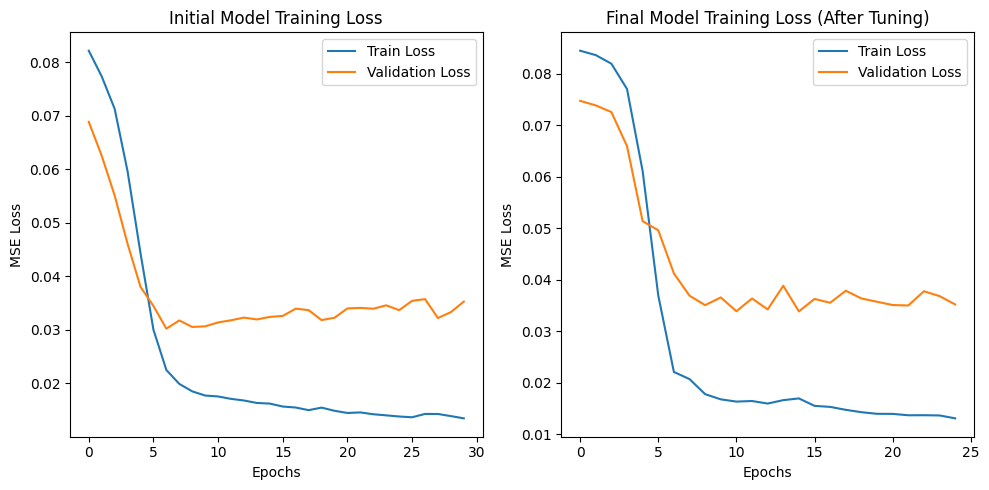

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


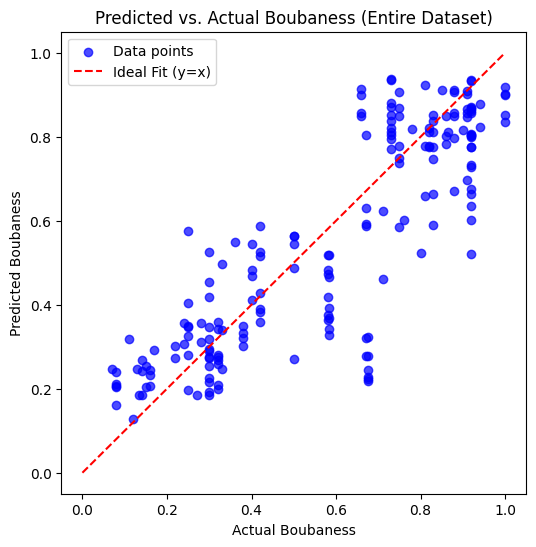

Correlation between Actual and Predicted Boubaness: 0.852


In [33]:
# ------------- Visualization ------------- #
# 1. Plot Training & Validation Loss for Both Models

plt.figure(figsize=(10, 5))

# Plot for Initial Model (from 'history')
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Initial Model Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()

# Plot for Final Model (from 'history_final')
plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title("Final Model Training Loss (After Tuning)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 2. Scatter Plot: Predicted vs. Actual Boubaness over Entire Dataset
# Use the final model to predict on all data X (or X_test if needed)
y_pred = final_model.predict(X)

plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.7, color='blue', label="Data points")
plt.plot([0, 1], [0, 1], 'r--', label="Ideal Fit (y=x)")
plt.xlabel("Actual Boubaness")
plt.ylabel("Predicted Boubaness")
plt.title("Predicted vs. Actual Boubaness (Entire Dataset)")
plt.legend()
plt.show()

# Optional: Print correlation between predicted and actual values
corr = np.corrcoef(y.flatten(), y_pred.flatten())[0,1]
print(f"Correlation between Actual and Predicted Boubaness: {corr:.3f}")


In [15]:
# Saves model to a file called "final_model.h5"
# final_model.save("final_model.keras")

# To load:
from tensorflow.keras.models import load_model
final_model = load_model("final_model.keras")

In [17]:
def generate_hybrid_name(bouba_score):
    """
    Return a hybrid pseudoword name.
    e.g., 0.7 => 'boubouki'
          0.4 => 'bouki'
    """
    # Ensure bouba_score is in [0,1]
    bouba_score = max(0, min(1, bouba_score))
    kiki_score = 1 - bouba_score
    
    # Decide how many times to repeat 'bou' vs. 'ki'
    # e.g., up to 3 repeats
    bou_repeats = int(round(bouba_score * 3))
    ki_repeats = int(round(kiki_score * 3))
    
    # Minimum 1 repeat if either part is nonzero
    if bouba_score > 0 and bou_repeats == 0:
        bou_repeats = 1
    if kiki_score > 0 and ki_repeats == 0:
        ki_repeats = 1
    
    name = "bou" * bou_repeats + "ki" * ki_repeats
    if not name:
        # edge case if both are 0 => 'bou' by default or empty
        name = "bou"
    
    return name

In [19]:
print(generate_hybrid_name(0.7))  
print(generate_hybrid_name(0.3))  
print(generate_hybrid_name(0.95)) 
print(generate_hybrid_name(0.5))  

boubouki
boukiki
bouboubouki
bouboukiki


In [21]:
print(generate_hybrid_name(0.9))

bouboubouki


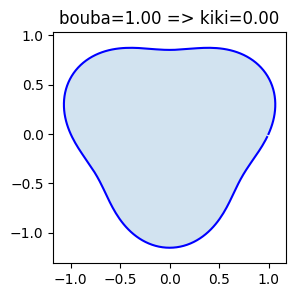

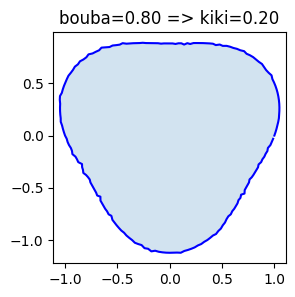

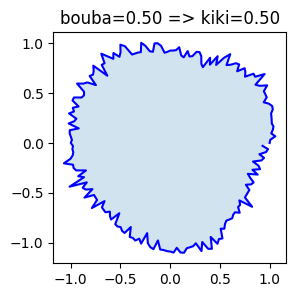

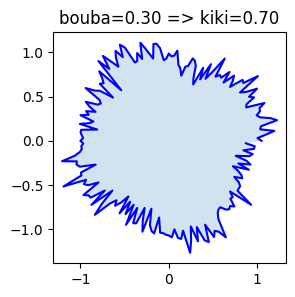

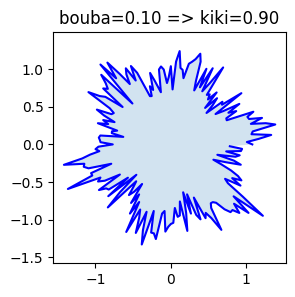

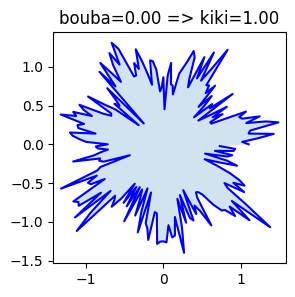

In [23]:
def generate_partial_spiky_shape(bouba_score, n_points=200, base_radius=1.0, seed=None):
    """
    A shape that:
      - Has a sinus wave for the 'bouba' portion.
      - Randomly designates a fraction of angles as 'spiky' 
        based on kiki_score => star wave + random lumps only there.
      - This yields partial spiky edges, partial smooth edges 
        at mid-range kiki values.
    """
    if seed is not None:
        np.random.seed(seed)
    
    kiki_score = 1.0 - bouba_score
    # Nonlinear scaling to flatten spikiness near mid-range, optional
    kiki_sq = kiki_score**2  

    angles = np.linspace(0, 2*np.pi, n_points, endpoint=False)

    # ---- (A) Sinus wave for bouba
    sinus_amp = 0.15 * bouba_score
    sinus_freq = 3
    sinus_component = sinus_amp * np.sin(sinus_freq * angles)

    # ---- (B) Star wave + random lumps for spiky angles
    star_freq = int(3 + 4 * kiki_sq)  # 3..7 lumps
    star_amp  = 0.2 * kiki_sq
    star_wave = star_amp * np.sin(star_freq * angles)
    
    random_amp = 0.2 * kiki_sq
    random_lumps = random_amp * np.random.randn(n_points)

    # ---- (C) Partial spikiness mask
    # Probability of an angle being 'spiky' = e.g. kiki_score or kiki_sq
    spiky_fraction = kiki_score + 0.2 # or kiki_sq if less spiky desried at mid-range
    mask = (np.random.rand(n_points) < spiky_fraction).astype(float)

    # For angles not in the spiky mask => star_wave & lumps = 0
    star_component   = star_wave * mask
    random_component = random_lumps * mask

    # ---- (D) Sum up everything
    r = base_radius + sinus_component + star_component + random_component

    # ---- (E) Clip
    r = np.clip(r, 0.05, None)

    # ---- (F) Convert polar -> Cartesian
    x = r * np.cos(angles)
    y = r * np.sin(angles)
    return x, y

def plot_shape(x, y, title=""):
    plt.figure(figsize=(3,3))
    plt.plot(x, y, '-b')
    plt.fill(x, y, alpha=0.2)
    plt.axis('equal')
    plt.title(title)
    plt.show()

# Demo
if __name__ == "__main__":
    for score in [1.0, 0.8, 0.5, 0.3, 0.1, 0.0]:
        x, y = generate_partial_spiky_shape(score, seed=42)
        plt_title = f"bouba={score:.2f} => kiki={(1-score):.2f}"
        plot_shape(x, y, plt_title)


In [25]:
def predict_bouba_score(word):
    """
    Uses the final_model to predict the bouba_score of 'word'.
    Assumes user has:
      - basic_phoneme_converter(word)
      - encode_and_pad(...)
      - final_model
      - max_len
    """
    # Convert word -> phoneme sequence
    phon_seq = basic_phoneme_converter(word)
    # Encode & pad
    X_input = np.array([encode_and_pad(phon_seq, max_len)])
    # Predict single output in [0,1]
    bouba_pred = final_model.predict(X_input, verbose=0)[0][0]
    return bouba_pred

def plot_shape(x, y, title=""):
    """Helper to plot the shape in a consistent style."""
    plt.figure(figsize=(3,3))
    plt.plot(x, y, '-b')
    plt.fill(x, y, alpha=0.2)
    plt.axis('equal')
    plt.title(title)
    plt.show()

def interactive_word_to_shape():
    """
    Lets user type in a word. We:
      - predict bouba_score
      - compute kiki_score = 1 - bouba_score
      - generate shape with generate_partial_spiky_shape
      - print scores + plot shape
    """
    while True:
        user_word = input("\nType a word (or 'quit' to exit): ")
        if user_word.lower() == "quit":
            print("Exiting.")
            break
        
        # Predict bouba/kiki
        bouba = predict_bouba_score(user_word)
        kiki  = 1.0 - bouba

        # Generate shape
        x, y = generate_partial_spiky_shape(bouba, seed=42)
        
        # Print
        print(f"Word: {user_word}")
        print(f"Bouba Score: {bouba:.3f}, Kiki Score: {kiki:.3f}")
        
        # Plot
        shape_title = f"{user_word} => bouba={bouba:.2f}, kiki={kiki:.2f}"
        plot_shape(x, y, shape_title)


Type a word (or 'quit' to exit):  bouba


Word: bouba
Bouba Score: 0.810, Kiki Score: 0.190


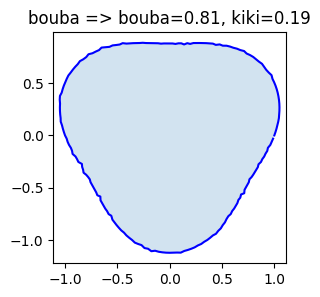


Type a word (or 'quit' to exit):  quit


Exiting.


In [27]:
if __name__ == "__main__":
    interactive_word_to_shape()